# Real Time Alignment and Distribution of Weather Radar Data with Rain Gauge Data for Deep Learning using CHORDS

## Authors

- Author1 = {"name": "Jay Potnis", "affiliation": "Colorado State University", "email": "jay.potnis@colostate.edu"}
- Author2 = {"name": "V.Chandrasekar", "affiliation": "Colorado State University", "email": "chandrasekaran.venkatachalam@colostate.edu"}
- Author3 = {"name": "Ryan Gooch", "affiliation": "Colorado State University", "email": "s.ryan.gooch@gmail.com"}

1373, Campus Delivery Colorado State University, Fort Collins CO 80523

## Purpose

- Quantitative Precipitation Estimation (QPE) based on weather radar observations plays a significant role in the understanding of weather events, especially in real-time, where fast evolving phenomena like convective storm cells can be dangerous. We wish to demonstrate QPE using deep learning as an alternative approach to empirical relationship equations between rainfall rate and reflectivity which were developed in the past. QPE using radar reflectivity is one of the possible applications of deep learning in the weather radar field. Preprocessing this data and saving it in real-time on cloud would let the users skip the time consuming preprocessing step and assist them to directly get to the deep learning phase. This notebook is a step towards using Deep Learning for making QPE work on-the-fly along with real time Radar measurements.

- To train and test deep learning models with radar data, we must align rain gauge data in space and time. This data preprocessing requires time and resource consuming processes that involve downloading, extracting, gridding, aligning the radar data with respect to every gauge in the region. If this preprocessed dataset was readily available in real-time, deep learning can be easily performed on it by anyone without going through the heavy computations required in the process. EarthCube’s CHORDS tool is a real-time data service that can be used to store preprocessed data on cloud so that it can be accessed whenever and wherever required.

- In this work, we demonstrate the steps involved in preprocessing such as accessing WSR-88D radar and NASA-TRMM rain gauge data, Cartesian gridding of radar data, aligning the radar data with gauge data in real-time. This aligned data is stored on cloud using CHORDS, so that it can be readily available to users who wish to use it for deep learning. The notebook will also demonstrate the procedure for storing and retrieving the dataset from CHORDS server and an example of the deep learning process on the downloaded dataset.


## Technical Contributions

- Implementation of data preprocessing involves downloading, gridding and aligning WSR-88D and NASA-TRMM rain gauge data required for Quantatitive Precipitation Estimation (QPE) using Deep Learning.
- Demonstration of a mechanism to store as well as retrive the processed data onto a CHORDS Portal based server. This mechanism can be used to process and store data in real time on the fly.
- Practical example of downloading data from the CHORDS Portal and training a Deep Learning model for QPE using Deep Learning.

## Methodology

1. To train and test deep learning models with radar data, we must first align rain gauge data in space and time. This data preprocessing requires time and resource consuming processes that involve downloading, extracting, gridding, aligning the radar data with respect to every gauge in the region. It is beneficial and easier to perform this step in real time as soon as data is obtained from radars.

2. After the data is constructed in the required format, EarthCube’s CHORDS tool can be used to store the data on the cloud so that it can be accessesed whenever and wherever required. CHORDS is a real-time data service for storing data on cloud.

3. After sufficient data is stored, we will use some historical data already stored on our cloud to train and test our Deep Learning model for QPE.

### Importing required libraries

- requests: The requests library is used to save data on the CHORDS Portal by making a sequence of http GET requests to the server.
- pandas, numpy: Used for data processing and organization.
- pyart: Radar library used for reading, displaying and analyzing radar data
- os, six, shutil: Used for file handling and file folder operations
- datetime: Used to represent time into standard format
- matplotlib: Plotting data
- geopy: For accurate distance calculation between coordinates
- pickle: Storing variables
- requests: This package is used for storing and retreiving data from the CHORDS Portal
- warnings: This package is used to silence the displaying of unnecessary warnings while executing

In [1]:
import requests
import pandas as pd
import numpy as np
import pyart
import os
import six
import nexradaws
from datetime import datetime
import shutil
import matplotlib.pyplot as plt
import geopy.distance
import pickle
import datetime as dt
import numpy.ma as ma
import time
import warnings
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Importing required functions

In this section we will import some custom made functions that are required for File Operations, Downloading and some basic processing required in this task. Reading these functions is not required for understanding this notebook. These functions can be accessed for reading in the following directory.

Main Directory > Tools > functions.py

The description of every imported function is given below.
- recreate_folder: Recreate folders to ensure that we do not have old files in our folders
- replace_if_nan: Function to replace the nan values in reflectivity to -9999
- download_radar_data: This function downloads WSR-88D radar data
- grid_data: This function grids the WSR-88D data using pyart

In [2]:
from Tools.functions import recreate_folder
from Tools.functions import replace_if_nan
from Tools.functions import download_radar_data
from Tools.functions import grid_data

### Functions for Data Preprocessing example (Download, Grid, calculate closest grid point with respect to gauges, align reflectivity and gauge observations)

- In this section, we have provided the individual functions that are used for Downloading, Gridding and then aligning the radar reflectivity with gauge observations. Downloading and Gridding the data requires a lot of time and storage space. But if a limited storage space is available, just like in our demonstration case, aligning and saving only the required information is very beneficial. After aligning is done we can delete the downloaded data as we do not require it again.


- The grid point matrix calculation is one of the critical steps required in aligning the radar and gauge data. The generate_grid_point_matrix function calculates the nearest radar observation gridpoint to every gauge in our dataset. This is a time and compute expensive step but as the positions of gauges relative to the radar always remain constant, we need to evaluate this matrix only once. We can reuse this matrix again for further alignment once it is calculated. Therefore, after creating the matrix, we will store in a .pkl file so that we can access it directly for future tasks.


- Later, the aligned data is stored on the CHORDS portal so that it can be used for our machine learning task later. The data is stored on the portal by making multiple GET requests to the server. If these steps are executed in real time, we could even use the data for real time prediction of the Rain Cases.

- Here is the link for our [CHORDS portal](http://ec2-18-220-56-38.us-east-2.compute.amazonaws.com/)

In [3]:
# This function creates a grid point matrix, where each gauge is assigned a gridpoint which is closest to gauge location
def generate_grid_point_matrix(gridded_data_folder, radar_filename, gauge_files, grid):
    grid_x, grid_y = grid.x['data'].shape[0], grid.y['data'].shape[0]
    grid_point_matrix = {"gauge_id": [],
                       "row_index": [],
                       "column_index": [],
                       "latitude": [],
                       "longitude": []}

    for gauge_file in gauge_files:
        gauge_data = pd.read_csv(gauge_csv_files + gauge_file)
        gauge_data = gauge_data.values
        latitude = gauge_data[1, 1]
        longitude = gauge_data[1, 2]
    
        #Find the distance of the gauge to every gridpoint location
        grid_latitude_matrix = grid.get_point_longitude_latitude(level=2)[1]
        grid_longitude_matrix = grid.get_point_longitude_latitude(level=2)[0]
        distance_matrix = grid.get_point_longitude_latitude(level=2)[0]
        distance_matrix[:, :] = 9999
        for coord1 in range(0,grid_x):
            for coord2 in range(0, grid_y):
                distance_matrix[coord1, coord2] = geopy.distance.distance((latitude, longitude),
                                                             (grid_latitude_matrix[coord1, coord2],
                                                             grid_longitude_matrix[coord1, coord2])).km

        #Find the closest gridpoint to the rain gauge
        gauge_id = int(gauge_file[0:3])
        min_distance = np.amin(distance_matrix)
        closest_grid_point = np.where(distance_matrix==min_distance)
        row_index, column_index = closest_grid_point[0][0], closest_grid_point[1][0]
        closest_lat_long = [grid_latitude_matrix[closest_grid_point[0], closest_grid_point[1]], grid_longitude_matrix[closest_grid_point[0], closest_grid_point[1]]]
        grid_point_matrix['gauge_id'].append(gauge_id)
        grid_point_matrix['row_index'].append(row_index)
        grid_point_matrix['column_index'].append(column_index)
        grid_point_matrix['latitude'].append(closest_lat_long[0][0])
        grid_point_matrix['longitude'].append(closest_lat_long[1][0])
    #Save the locations of grid points in a variable file
    with open('grid_point_matrix.pkl', 'wb') as f:
        pickle.dump(grid_point_matrix, f)
    print(f'Grid point matrix created and saved in pkl file')
    return grid_point_matrix


# This functions finally aligns the radar and gauge data by using the grid_point_matrix calculated by us
def align_and_push_to_CHORDS(grid, grid_point_matrix, gauge_files, radar_filename):
    gauge_time_stamps = {}
    gauge_data = {}
    for gauge_file in gauge_files:
        gauge_data[f'{int(gauge_file[0:3])}'] = pd.read_csv(gauge_csv_files + gauge_file).values
        gauge_time_stamps[f'{int(gauge_file[0:3])}'] = []
        for count in range(0, gauge_data[f'{int(gauge_file[0:3])}'].shape[0]):
            gts = []
            for ct in range(3, gauge_data[f'{int(gauge_file[0:3])}'].shape[1]):
                gts.append(int(gauge_data[f'{int(gauge_file[0:3])}'][count, ct]))
            gauge_time_stamps[f'{int(gauge_file[0:3])}'].append(dt.datetime(gts[0], gts[1], gts[2], gts[3], gts[4]))
        gauge_time_stamps[f'{int(gauge_file[0:3])}'] = np.asarray(gauge_time_stamps[f'{int(gauge_file[0:3])}']).reshape(-1, 1)

    max_buffer = dt.timedelta(minutes=5)
    min_buffer = dt.timedelta()

    grid.fields['reflectivity']['data'][1].mask = ma.nomask
    grid_x, grid_y = grid.x['data'].shape[0], grid.y['data'].shape[0]
    grid_site = radar_filename[0:4]
    grid_year = int(radar_filename[4:8])
    grid_month = int(radar_filename[8:10])
    grid_day = int(radar_filename[10:12])
    grid_hour = int(radar_filename[13:15])
    grid_min = int(radar_filename[15:17])
    grid_sec = int(radar_filename[17:19])
    grid_timestamp = dt.datetime(grid_year, grid_month, grid_day, grid_hour, grid_min, grid_sec)
    for gauge_file in gauge_files:
        gauge_id = int(gauge_file[0:3])
        avg_rr = 0
        rain_rates = gauge_data[f'{gauge_id}'][np.where((gauge_time_stamps[f'{gauge_id}'] - grid_timestamp <= max_buffer) & (gauge_time_stamps[f'{gauge_id}'] -grid_timestamp >= min_buffer))[0], -1].reshape(-1, 1)
        rain_rates[np.where(rain_rates < 0)] = 0
        if (rain_rates.shape[0] == 0):
            avg_rr = 0
            rain_class = 0
        else:
            avg_rr = np.sum(rain_rates)/rain_rates.shape[0]
            rain_class = 1
        grid_index = grid_point_matrix['gauge_id'].index(gauge_id)
        row_index, column_index = grid_point_matrix['row_index'][grid_index], grid_point_matrix['column_index'][grid_index]
        alt_1 = replace_if_nan(grid.fields['reflectivity']['data'][0][row_index, column_index])
        alt_2 = replace_if_nan(grid.fields['reflectivity']['data'][1][row_index, column_index])
        alt_3 = replace_if_nan(grid.fields['reflectivity']['data'][2][row_index, column_index])
        alt_4 = replace_if_nan(grid.fields['reflectivity']['data'][3][row_index, column_index])
        reflectivity_array = np.asarray([alt_1, alt_2, alt_3, alt_4])
        reflectivity_array[np.where(reflectivity_array == -9999)] = -25
        push_to_CHORDS_portal(gauge_id, reflectivity_array, avg_rr, rain_class, grid_year, grid_month, grid_day, grid_hour, grid_min, grid_sec)
    print(f'Gauge and Radar data ')

# Finally this function stores the aligned data on the CHORDS Server
def push_to_CHORDS_portal(gauge_id, reflectivity_array, avg_rr, rain_class, grid_year, grid_month, grid_day, grid_hour, grid_min, grid_sec):
    #save gauge information and corresponding radar reflectivity
    time.sleep(0.2)
    gauge_url = f'http://ec2-18-220-56-38.us-east-2.compute.amazonaws.com/measurements/url_create?sensor_id={gauge_id}&rr={avg_rr}&rc={rain_class}&ref_1p5={reflectivity_array[0]}&ref_2p5={reflectivity_array[1]}&ref_3p5={reflectivity_array[2]}&ref_4p5={reflectivity_array[3]}&at={int(grid_year):04}-{int(grid_month):02}-{int(grid_day):02}T{int(grid_hour):02}:{int(grid_min):02}:{int(grid_sec):02}&email=measurer@me&api_key=EWETsZ9SfzGPsbXT7LTJ&test'
    gauge_response = requests.get(url=gauge_url)

### Implementation of data preprocessing using the functions defined above.

Now that we have our preprocessing functions defined, we will execute these functions to create a small dataset. This section gives a small demonstration of the process that we will be following by processing 2-3 radar files with 19 gauges. This same procedure can be easily used for real time operations by just changing the dates and timestamps. As aligning also depends on the rain gauge data, remember to also download the rain gauge data before changing the timestamps in the given code. We have included the gauge dataset for the year 2017 along with this notebook, so feel free to explore any date for the year 2017.

In [4]:
# This section of code runs the functions that Download, Grid, Align and Save the aligned data on CHORDS Portal

# Set folder paths and recreate all the folders
download_folder = './downloaded_data/'
unzipped_data_folder = './unzipped_data/'
gridded_data_folder = './gridded_data/'
gauge_csv_files = './gauge_data/'

gauge_files = sorted(os.listdir(gauge_csv_files))

recreate_folder(download_folder)
recreate_folder(unzipped_data_folder)
recreate_folder(gridded_data_folder)

# Set the dates for which we want to create a dataset
conn = nexradaws.NexradAwsInterface()
radar_name = 'KMLB'
start = datetime(2017,7,23,1,3) #year, month, day, hour, minute
end = datetime(2017,7,23,1, 12) #year, month, day, hour, minute
scans = conn.get_avail_scans_in_range(start, end, radar_name)

for scan_index in range(0, len(scans)):
    # Download WSD-88D data
    radar_filename = download_radar_data(download_folder, unzipped_data_folder, scans[scan_index])
    if '_MDM' not in radar_filename:
        # Grid the downloaded data
        grid = grid_data(unzipped_data_folder, gridded_data_folder, radar_filename)
    if scan_index == 0:
        # Calculate the grid point matrix using the first downloaded data file
        grid_point_matrix = generate_grid_point_matrix(gridded_data_folder, radar_filename, gauge_files, grid)
    # Save data on the CHORDS portal
    align_and_push_to_CHORDS(grid, grid_point_matrix, gauge_files, radar_filename)

Downloaded KMLB20170723_010431_V06
1 out of 1 files downloaded...0 errors
Gridding Successful on KMLB20170723_010431_V06
Grid point matrix created and saved in pkl file
Gauge and Radar data 
Downloaded KMLB20170723_010925_V06
1 out of 1 files downloaded...0 errors
Gridding Successful on KMLB20170723_010925_V06
Gauge and Radar data 


- As we can see that downloading, reading, gridding and aligning data takes a lot of time. It would be beneficial if this whole process was done in real-time so that the observations would be available to users for estimation of the class of rainfall in real time.

- We have already performed this whole process for some data and saved it on our CHORDS portal. We will now download this previously pre-processed data for the demonstration of our Deep learning approach.

### Downloading data from the CHORDS portal

Now that we have seen the preprocessing procedure involved,let us start with the Deep learning part of the project. To speed up the process, we will demonstrate the Deep Learning procedure on July and August 2017 data which we have already saved on our CHORDS Portal. This section of the project downloads the data from the Portal.

In [8]:
def download_data(sensor_id):
    download_url = f'http://ec2-18-220-56-38.us-east-2.compute.amazonaws.com/api/v1/data/{sensor_id}.csv?start=2015-08-01T00:30&end=2021-05-15T01:30'
    req = requests.get(download_url, allow_redirects=True)
    time.sleep(0.2)
    open('sensor.csv', 'wb').write(req.content)

def remove_header_and_save():
    f = open("sensor.csv", "r")
    lines = f.readlines()
    f.close()
    f = open("sensor.csv", "w")
    f.writelines(lines[18:])
    f.close()
    file = pd.read_csv('sensor.csv', delimiter=',')
    val = file.values
    return val

In [9]:
for id in range(1, 45):
    download_data(id)
    values = remove_header_and_save()
    try:
        _ = dataset.shape
        dataset = np.concatenate((dataset, values), axis = 0)
    except:
        dataset = values

### Visualizing the downloaded data

- In this section we will visualize the downloaded data. This step hepls us to verify the integrity of the data.
- The below graph plots the Vertical profile of the radar (X-axis) and Rain rate of gauges (Y-axis).

Text(0.5, 1.0, 'Reflectivity vs Rain Rate')

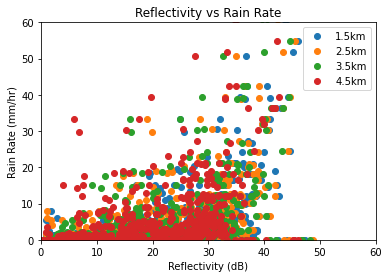

In [10]:
plt.plot(list(dataset[:, 3]), list(dataset[:, 1]), 'o', label='1.5km')
plt.plot(list(dataset[:, 4]), list(dataset[:, 1]), 'o', label='2.5km')
plt.plot(list(dataset[:, 5]), list(dataset[:, 1]), 'o', label='3.5km')
plt.plot(list(dataset[:, 6]), list(dataset[:, 1]), 'o', label='4.5km')
plt.xlabel('Reflectivity (dB)')
plt.ylabel('Rain Rate (mm/hr)')
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.legend(loc=1)
plt.title(f'Reflectivity vs Rain Rate')

### Quantative Precipitation Estimation using Deep Learning

- This is the final section of our notebook. In this section we have represented how a Deep Learning model is used for Classification of Precipitation based on our downloaded dataset.
- As the number of observations for No-Rain Classes are greater that the observations of Rain Classes, we need to use class weights in the loss function to make the model work better. The samples of No-Rain classes would always be less than the Rain Class samples because Rain is an uncommon phenomenon as compared to No-rain. Because this is one of the major factors affecting the effectiveness of Deep Learning on data, this is one of the critical steps that need to be performed to make the model work well.

In [11]:
# First we need to import all the packages required to train and test our model 
# Tensorflow and Keras are used for implementing Deep Learning functions.
# sklean is used for splitting and scaling data.

import tensorflow as tf;
from tensorflow import keras;

from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import StandardScaler;

In [12]:
# Split the available data into training, validation and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=True)

# Split each set into features and labels
X_train, T_train = train_data[:, 3:], train_data[:, 2].reshape(-1, 1).astype('float64')
X_val, T_val = val_data[:, 3:], val_data[:, 2].reshape(-1, 1).astype('float64')
X_test, T_test = test_data[:, 3:], test_data[:, 2].reshape(-1, 1).astype('float64')
print(f'Shapes of training, validation and testing sets: \n{X_train.shape, T_train.shape, X_val.shape, T_val.shape, X_test.shape, T_test.shape}')

Shapes of training, validation and testing sets: 
((3091, 4), (3091, 1), (773, 4), (773, 1), (967, 4), (967, 1))


In [13]:
#Calculate the ratio of Rain vs No_Rain cases
no_rain, rain = np.bincount(pd.DataFrame(dataset, columns = ['timestamp', 'rr', 'rc', 'r_1', 'r_2', 'r_3', 'r_4'])['rc'])
total_samples = no_rain + rain
print('Examples:\n Total: {}\n Positive: {} ({:.2f}% of total)\n'.format(total_samples, rain, 100*rain/total_samples))

Examples:
 Total: 4831
 Positive: 437 (9.05% of total)



In [14]:
# Need to scale Radar Reflectivity
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val, X_test = sc.transform(X_val), sc.transform(X_test)
X_train, X_val, X_test = np.clip(X_train, -5, 5), np.clip(X_val, -5, 5), np.clip(X_test, -5, 5)

In [15]:
# Calculating the class weights to solve class imbalance problem.
#  These values will be used in the Binary Crossentropy Loss function during training.

no_rain_weight, rain_weight = (1/no_rain)*(total_samples)/2.0, (1/rain)*(total_samples)/2.0

class_weight = {0: no_rain_weight, 1: rain_weight}

print('Weight for No_rain Class: {:.2f}'.format(no_rain_weight))
print('Weight for class 1: {:.2f}'.format(rain_weight))

Weight for No_rain Class: 0.55
Weight for class 1: 5.53


In [16]:
# Function for defining our DNN model
def make_model():
    model = tf.keras.Sequential([
        keras.layers.Dense(18, activation='relu', input_dim=X_train.shape[1]),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=keras.metrics.BinaryAccuracy(name='accuracy'))
    return model

# Make the model and train it on training data and validate on validation data
model = make_model()
history = model.fit(X_train, T_train, batch_size = 64, epochs = 10, validation_data = (X_val, T_val), class_weight=class_weight)

Epoch 1/10
49/49 [==============================] - 2s 21ms/step - loss: 0.6321 - accuracy: 0.4244 - val_loss: 0.5838 - val_accuracy: 0.7555
Epoch 2/10
49/49 [==============================] - 0s 5ms/step - loss: 0.4470 - accuracy: 0.7672 - val_loss: 0.4945 - val_accuracy: 0.7995
Epoch 3/10
49/49 [==============================] - 0s 7ms/step - loss: 0.3631 - accuracy: 0.7780 - val_loss: 0.4292 - val_accuracy: 0.8098
Epoch 4/10
49/49 [==============================] - 0s 6ms/step - loss: 0.3425 - accuracy: 0.7810 - val_loss: 0.3795 - val_accuracy: 0.8215
Epoch 5/10
49/49 [==============================] - 0s 7ms/step - loss: 0.2915 - accuracy: 0.8117 - val_loss: 0.3460 - val_accuracy: 0.8344
Epoch 6/10
49/49 [==============================] - 0s 6ms/step - loss: 0.2820 - accuracy: 0.8306 - val_loss: 0.3155 - val_accuracy: 0.8525
Epoch 7/10
49/49 [==============================] - 0s 8ms/step - loss: 0.2541 - accuracy: 0.8516 - val_loss: 0.2965 - val_accuracy: 0.8616
Epoch 8/10
49/49 [=

## Results

Let's take a look at the output of the Deep Learning model and evaluate it by examining the loss curve and Confusion matrix.

Text(0.5, 1.0, 'Training Loss Curve')

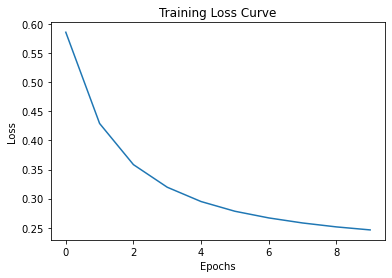

In [17]:
# Let us take a look at the loss change during training
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss Curve')

In [18]:
# The functions in this section are used to print the confusion matrix

def percent_correct(Y, T):
        return np.mean(Y==T) * 100
    

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")
    print(f'Percent Correct is {percent_correct(Y_classes, T)}')
    return conf_matrix


# Function to binarize the values predicted by our model
def binarize(predictions, threshold):
    for index in range(0, predictions.shape[0]):
        if (predictions[index, 0] > threshold):
            predictions[index, 0] = 1
        else:
            predictions[index, 0] = 0
    return predictions

In [19]:
# Predict the class values of our test set
model_output = model.predict(X_test)
binarized_classes = binarize(model_output, 0.5)

# Print the confusion matrix of the training set
conf_matrix = confusion_matrix(binarized_classes, T_test)
print(conf_matrix)

Percent Correct is 89.24508790072389
           0.0        1.0
0.0  88.926554  11.073446
1.0   7.317073  92.682927


The confusion matrix represents the effectiveness of the model in classifying the data. Here is the format of the confusion matrix.

|  | Predicted No-Rain | Predicted Rain |
| --- | --- | --- |
| **Actual No-Rain events** | True Negatives | False Positives |
| **Actual Rain events** | False Negatives | True Positives |

As the purpose is always to successfully detect the rain cases, two most important quantities for analyzing the model is the percent of True Positives and False Negatives. The value of True Positives should be as high as possible (maximum 100%) and the value of False Negatives should be as low as possible (minimun 0%).

## Keywords
keywords=["Quantative Precipitation Estimation (QPE)", "Deep Learning", "Rain Classification", "Radar data aligning", "Cloud Hosted Real Time Data (CHORDS)"]

## Citation


1.   `Michael D. Daniels, Branko Kerkez, V. Chandrasekar, Sara Graves, D. Sarah Stamps, Charles Martin, Aaron Botnick, Michael Dye, Ryan Gooch, Josh Jones, Ken Keiser, Matthew Bartos, Thaovy Nguyen, Robyn Collins, Sophia Chen, Terrie Yang, Abbi Devins-Suresh (2016). Cloud-Hosted Real-time Data Services for the Geosciences (CHORDS) software (Version 1.0.1). UCAR/NCAR - EarthCube. https://doi.org/10.5065/d6v1236q`
2.  `H. Liu, V. Chandrasekar and E. Gorgucci, "Detection of rain/no rain condition on the ground based on radar observations," in IEEE Transactions on Geoscience and Remote Sensing, vol. 39, no. 3, pp. 696-699, March 2001, doi: 10.1109/36.911127.`
